# Creating sediment input into Landlab NetworkSedimentTransporter component

#### This lab was created by graduate students as part of the 2021 CSDMS ESPIn (Earth Surface Processes Institute).**

#### Creators
Marius - 
Mel Guirro - Durham University
Muneer - 
Se Jong - 


For more Landlab tutorials, click here: https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html


## Notebook Overview

This notebook will...

### Learning Objectives
Topical learning objectives:
1. Fluvial sediment processes through  river network

### Landlab Components used

## Conceptual Model

Add here framework

## Load the necessary packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab.plot import plot_network_and_parcels

%matplotlib inline

## Create the river network model grid

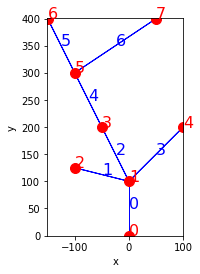

In [2]:
y_of_node = (0, 100, 200, 200, 300, 400, 400, 125)
x_of_node = (0, 0, 100, -50, -100, 50, -150, -100)

nodes_at_link = ((1, 0), (2, 1), (1, 7), (3, 1), (3, 4), (4, 5), (4, 6))

grid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)

plt.figure(0)
graph.plot_graph(grid, at="node,link")

In [3]:
grid.at_node["topographic__elevation"] = [0.0, 0.08, 0.25, 0.15, 0.25, 0.4, 0.8, 0.8]
grid.at_node["bedrock__elevation"] = [0.0, 0.08, 0.25, 0.15, 0.25, 0.4, 0.8, 0.8]

grid.at_link["flow_depth"] = 2.5 * np.ones(grid.number_of_links) # m
grid.at_link["reach_length"] = 200*np.ones(grid.number_of_links) # m
grid.at_link["channel_width"] = 1*np.ones(grid.number_of_links) # m

## Create sediment 'parcels' in a DataRecord

In [4]:
# element_id is the link on which the parcel begins. 
element_id = np.repeat(np.arange(grid.number_of_links),30)
element_id = np.expand_dims(element_id, axis=1)

volume = 0.05*np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Lognormal GSD
medianD = 0.085 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

In [5]:
time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 

In [6]:
lithology = ["quartzite"] * np.size(element_id)

In [15]:
variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}

In [8]:
items = {"grid_element": "link", "element_id": element_id}

parcels = DataRecord(
    grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

## Run the Network Sediment Transporter

In [9]:
timesteps = 10 # total number of timesteps
dt = 60 * 60 * 24 *1 # length of timestep (seconds) 

In [10]:
fd = FlowDirectorSteepest(grid, "topographic__elevation")
fd.run_one_step()

In [11]:
nst = NetworkSedimentTransporter(    
    grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

In [12]:
for t in range(0, (timesteps * dt), dt):
    nst.run_one_step(dt)    
    print("Model time: ", t/dt, "timesteps passed")

Model time:  0.0 timesteps passed
Model time:  1.0 timesteps passed
Model time:  2.0 timesteps passed
Model time:  3.0 timesteps passed
Model time:  4.0 timesteps passed
Model time:  5.0 timesteps passed
Model time:  6.0 timesteps passed
Model time:  7.0 timesteps passed
Model time:  8.0 timesteps passed
Model time:  9.0 timesteps passed


## Plot the model results

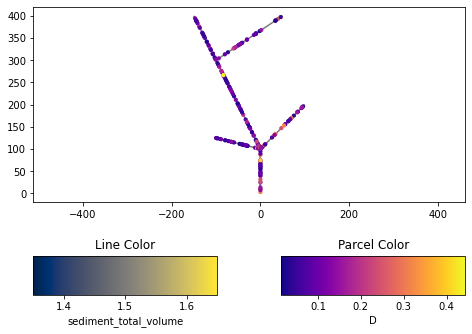

In [13]:
fig = plot_network_and_parcels(
    grid, parcels, 
    parcel_time_index=0, 
    parcel_color_attribute="D",
    link_attribute="sediment_total_volume", 
    parcel_size=10, 
    parcel_alpha=1.0)

Text(0, 0.5, 'Cumulative parcel travel distance')

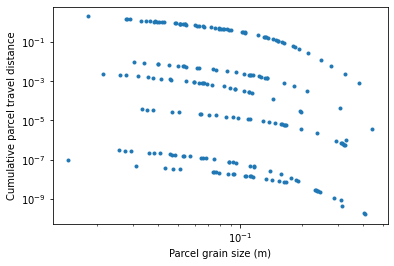

In [14]:
plt.loglog(parcels.dataset.D[:,-1],
         nst._distance_traveled_cumulative,
         '.'
        )
plt.xlabel('Parcel grain size (m)')
plt.ylabel('Cumulative parcel travel distance')

# Note: some of the smallest grain travel distances can exceed the length of the 
# grid by "overshooting" during a single timestep of high transport rate


## Run it again changing parameters